In [1]:
import sys

import networkx as nx
#from networkx.generators.community import LFR_benchmark_graph

import numpy as np
import time

import matplotlib.pyplot as plt

#sys.path.append("/home/oriol/Documents/Trento/JacobianGeometry/Code/Dynamics_v2/")
sys.path.append("/Users/giacomobarzon/Desktop/jacobian_geometry/Code_8thJune/Dynamics_v2/")

import CommonFunctions as cf

In [3]:
#Creating ER network
N = 50
pp = 5./N #mean degree 5

G_er = nx.fast_gnp_random_graph(N, pp)
while nx.is_connected(G_er) == 0:
    print('The network should be in a single component. New trial!')
    G_er = nx.fast_gnp_random_graph(N, pp)

infoG = ['ER',pp]

print('Mean degree', np.mean(list(dict(G_er.degree()).values())))

Mean degree 4.92


In [3]:
def Simu(dynamics, G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    num_time_points = 100 # small to decrease computational load
    times = np.linspace(0, 100, num = num_time_points) #time to find the steady state    
    str_tp = "np.logspace(-2, 2., num = num_time_points)" #times at which we look how the perturbation evolves
    times_perturbation = eval(str_tp)

    if dynamics in ['Mutualistic', 'Population', 'Regulatory','Synchronization', 'Neuronal']:
        perturbation_strength = 0.5
    elif dynamics in ['Biochemical', 'Epidemics', 'NoisyVM']:
        perturbation_strength = 0.05
    else:
        print('Dynamics not valid. Manual Exiting')
        exit()
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    

    #Integration to get the steady state
    initial_state = np.random.random(len(G.nodes()))   
#    initial_state = np.ones(len(G.nodes()))

    SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
#        SteadyState_ref = SteadyState_ref[-1]/max(SteadyState_ref[-1])
    SteadyState_ref = SteadyState_ref[-1]

    ## METHOD 1
    # analytical expression of Jacobian
    d_t = cf.Jacobian(G, dynamics, SteadyState_ref, 
                      perturbation_strength, times_perturbation)

    ## METHOD 2
    # integration of perturbed dynamics
    mean_d = np.zeros(num_time_points)
    d_ij = np.zeros((num_time_points,num_nodes,num_nodes))
        
    c = 0
    for node1 in range(0, num_nodes):
      print(node1)
      for node2 in range(node1, num_nodes):
          if node1 != node2:
            Perturbed_SteadyState = cf.Numerical_Integration_perturbation(G,dynamics,SteadyState_ref,
                                                                          node1,node2, perturbation_strength,
                                                                          times = times_perturbation,
                                                                          fixed_node = 1e+6, show = 0)

#                delta1 = abs(Perturbed_SteadyState[:,node1] - SteadyState_ref[node1])
#                delta2 = abs(Perturbed_SteadyState[:,node2] - SteadyState_ref[node2])
#                d_tmp = abs(delta1 - delta2)
#                mean_d += d_tmp

            delta1 = Perturbed_SteadyState[:,node1] - SteadyState_ref[node1]
            delta2 = Perturbed_SteadyState[:,node2] - SteadyState_ref[node2]
            d_tmp = np.sqrt(delta1*delta1 + delta2*delta2)
            
#            if d_tmp != 0:
            c+=1
            mean_d += d_tmp

            if 0 in d_tmp:
                print('0 inside ', c)

            d_ij[:, node1,node2] = d_tmp
            
    d_ij = d_ij/c
    mean_d = mean_d/c
    
    #cf.PrintFiles(mean_d, d_t, d_ij, times_perturbation, str_tp, dynamics, G, infoG)

    print("--- %s seconds ---" % (time.time() - start_time))

    return d_t, mean_d


In [4]:
def mySimu(dynamics, G, infoG):
    """
    Inputs: dynamics (any from  dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory',
                                                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM'])
            Network topology G
            infoG (list): Info about the network. infoG[0] = network_type; infoG[i>0] = parameters
    """
    start_time = time.time()
    
    num_nodes = G.number_of_nodes()
    num_time_points = 100 # small to decrease computational load
    times = np.linspace(0, 100, num = num_time_points) #time to find the steady state    
    str_tp = "np.logspace(-2, 2., num = num_time_points)" #times at which we look how the perturbation evolves
    times_perturbation = eval(str_tp)

    if dynamics in ['Mutualistic', 'Population', 'Regulatory','Synchronization', 'Neuronal']:
        perturbation_strength = 0.5
    elif dynamics in ['Biochemical', 'Epidemics', 'NoisyVM']:
        perturbation_strength = 0.05
    else:
        print('Dynamics not valid. Manual Exiting')
        exit()
    
    if nx.is_connected(G) == 0:
        raise ValueError('The network should be in a single component. Exit!')
    

    #Integration to get the steady state
    initial_state = np.random.random(len(G.nodes()))   
#    initial_state = np.ones(len(G.nodes()))

    SteadyState_ref = cf.Numerical_Integration(G, dynamics, initial_state, times = times, fixed_node = 1e+6, show = 1)
#        SteadyState_ref = SteadyState_ref[-1]/max(SteadyState_ref[-1])
    SteadyState_ref = SteadyState_ref[-1]

    ## METHOD 1
    # analytical expression of Jacobian
    print('------- JACOBIAN COMPUTATION -------')
    d_t = cf.myJacobian(G, dynamics, SteadyState_ref, 
                      perturbation_strength, times_perturbation)

    ## METHOD 2
    # simulate perturbation for each node
    print('------- INTEGRATION COMPUTATION -------')
    perturbed = []
    for node in range(num_nodes):
        Perturbed_SteadyState = cf.myNumerical_Integration_perturbation(G,dynamics,SteadyState_ref,
                                                                          node, perturbation_strength,
                                                                          times = times_perturbation,
                                                                          fixed_node = 1e+6, show = 0)
        perturbed.append(Perturbed_SteadyState)
    
    # compute distance
    mean_d = np.zeros(num_time_points)
    d_ij = np.zeros((num_time_points,num_nodes,num_nodes))
    
    for t in range(num_time_points):
        print("t: ",t)
        for node_i in range(num_nodes):
            for node_j in range(node_i+1, num_nodes):
                d_tmp = perturbed[node_i][t] - perturbed[node_j][t]
                d_tmp = np.sqrt(d_tmp.dot(d_tmp))
            
                mean_d[t] += d_tmp

                d_ij[t,node_i,node_j] = d_tmp
            
    d_ij = d_ij * 2 / num_nodes / (num_nodes-1)
    mean_d = mean_d * 2 / num_nodes / (num_nodes-1)
    
    #cf.PrintFiles(mean_d, d_t, d_ij, times_perturbation, str_tp, dynamics, G, infoG)
    
    ## METHOD 3
    # old integration of perturbed dynamics
    mean_d_old = np.zeros(num_time_points)
    d_ij_old = np.zeros((num_time_points,num_nodes,num_nodes))
        
    c = 0
    for node1 in range(0, num_nodes):
      print(node1)
      for node2 in range(node1, num_nodes):
          if node1 != node2:
            Perturbed_SteadyState = cf.Numerical_Integration_perturbation(G,dynamics,SteadyState_ref,
                                                                          node1,node2, perturbation_strength,
                                                                          times = times_perturbation,
                                                                          fixed_node = 1e+6, show = 0)

#                delta1 = abs(Perturbed_SteadyState[:,node1] - SteadyState_ref[node1])
#                delta2 = abs(Perturbed_SteadyState[:,node2] - SteadyState_ref[node2])
#                d_tmp = abs(delta1 - delta2)
#                mean_d += d_tmp

            delta1 = Perturbed_SteadyState[:,node1] - SteadyState_ref[node1]
            delta2 = Perturbed_SteadyState[:,node2] - SteadyState_ref[node2]
            d_tmp = np.sqrt(delta1*delta1 + delta2*delta2)
            
#            if d_tmp != 0:
            c+=1
            mean_d_old += d_tmp

            if 0 in d_tmp:
                print('0 inside ', c)

            d_ij_old[:, node1,node2] = d_tmp
            
    d_ij_old = d_ij_old/c
    mean_d_old = mean_d_old/c

    print("--- %s seconds ---" % (time.time() - start_time))

    return d_t, mean_d, mean_d_old



In [ ]:
dyn = 'Epidemics'

Simu(dyn,G_er,infoG)

Epidemics dynamics


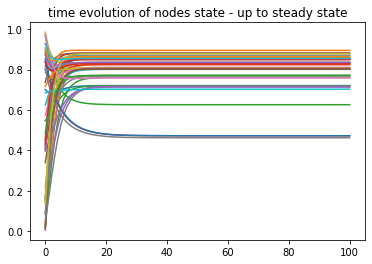

------- JACOBIAN COMPUTATION -------


/Users/giacomobarzon/Desktop/jacobian_geometry/Code_8thJune/Dynamics_v2/CommonFunctions.py:324: RuntimeWarning: invalid value encountered in true_divide
  J2 = J/J


------- INTEGRATION COMPUTATION -------
t:  0
t:  1
t:  2
t:  3
t:  4
t:  5
t:  6
t:  7
t:  8
t:  9
t:  10
t:  11
t:  12
t:  13
t:  14
t:  15
t:  16
t:  17
t:  18
t:  19
t:  20
t:  21
t:  22
t:  23
t:  24
t:  25
t:  26
t:  27
t:  28
t:  29
t:  30
t:  31
t:  32
t:  33
t:  34
t:  35
t:  36
t:  37
t:  38
t:  39
t:  40
t:  41
t:  42
t:  43
t:  44
t:  45
t:  46
t:  47
t:  48
t:  49
t:  50
t:  51
t:  52
t:  53
t:  54
t:  55
t:  56
t:  57
t:  58
t:  59
t:  60
t:  61
t:  62
t:  63
t:  64
t:  65
t:  66
t:  67
t:  68
t:  69
t:  70
t:  71
t:  72
t:  73
t:  74
t:  75
t:  76
t:  77
t:  78
t:  79
t:  80
t:  81
t:  82
t:  83
t:  84
t:  85
t:  86
t:  87
t:  88
t:  89
t:  90
t:  91
t:  92
t:  93
t:  94
t:  95
t:  96
t:  97
t:  98
t:  99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
--- 79.0454089641571 seconds ---


In [8]:
dynamics_list = ['Mutualistic', 'Biochemical', 'Population', 'Regulatory', 
                 'Epidemics','Synchronization', 'Neuronal', 'NoisyVM']

results = []

for dyn in dynamics_list[4:5]:
    print(dyn, 'dynamics')
    tmp_res = mySimu(dyn,G_er,infoG)
    results.append(tmp_res)

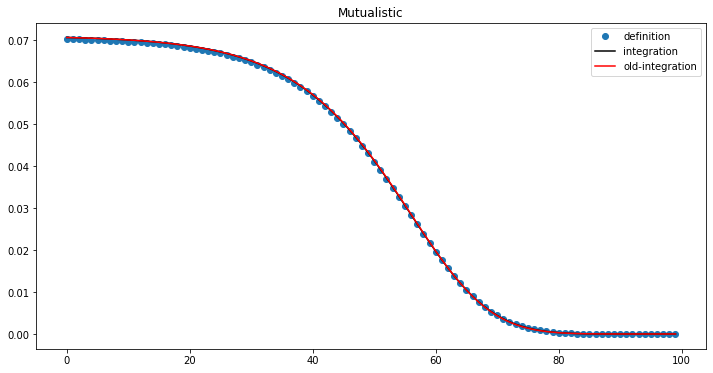

In [9]:
plt.figure(figsize=(12,6))

plt.plot(results[0][0], 'o', label='definition')
plt.plot(results[0][1], label='integration', c='k')
plt.plot(results[0][2], label='old-integration', c='r')

plt.title(dynamics_list[0])

plt.legend()
plt.show()

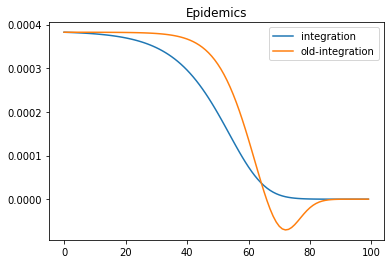

In [14]:
#plt.plot(results[0][0], label='definition')
plt.plot( (results[0][1]-results[0][0])**2, label='integration')
plt.plot( (results[0][2]-results[0][0])**2, label='old-integration')

plt.title(dynamics_list[4])

plt.legend()
plt.show()